# Physics informed relevant information simulation (PIRIS)
**Comparación con el artículo de DFT**


# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

2025-07-18 01:47:36.068878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752803256.378320      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752803256.465780      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Parametros de creación de la muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6

# Parametros del potencial L-J
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 * kj_mol_to_ev #Fondo del pozo del Oxigeno (eV/atom)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 *kj_mol_to_ev #Fondo del pozo Niquel (ev/atom)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 *kj_mol_to_ev #Fondo del pozo Zinc (ev/atom)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 

# Parametros potencial coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
q_Ni = 2 #(carga del electron e)
q_O = -0.86 #(carga del electron e)
q_Zn = 0.86 #(carga del electron e)

# Radios de corte de intereacción basados en el potencial L-J
r_cutoffO_Ni = 2.5*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 2.5*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 2.5*SigmaNi #Radio maximo de interacción Ni-Ni(A)

In [3]:
# Casteamos a tf los parametros
SigmaO_Ni = tf.cast(SigmaO_Ni, tf.float32)
EpsilonO_Ni = tf.cast(EpsilonO_Ni, tf.float32)
SigmaZn_Ni = tf.cast(SigmaZn_Ni, tf.float32)
EpsilonZn_Ni = tf.cast(EpsilonZn_Ni, tf.float32)
SigmaNi_Ni = tf.cast(SigmaNi, tf.float32)
EpsilonNi_Ni = tf.cast(EpsilonNi, tf.float32)
k_e = tf.cast(k_e,tf.float32)
q_Ni = tf.cast(q_Ni,tf.float32)
q_O = tf.cast(q_O,tf.float32)
q_Zn = tf.cast(q_Zn,tf.float32)
r_cutoffO_Ni = tf.cast(r_cutoffO_Ni, tf.float32)
r_cutoffZn_Ni = tf.cast(r_cutoffZn_Ni, tf.float32)
r_cutoffNi_Ni = tf.cast(r_cutoffNi_Ni, tf.float32)

2025-07-18 01:47:58.392639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Creación de la muestra 1: ZnO en forma Grafeno

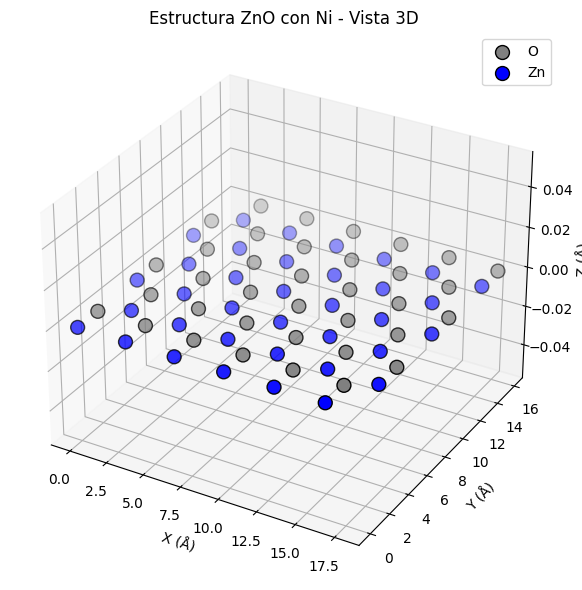

In [4]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)



num_atoms = len(positions)
positions = np.array(positions)
elements = np.array(elements)

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

# Creación de los iones que se van a adsorber

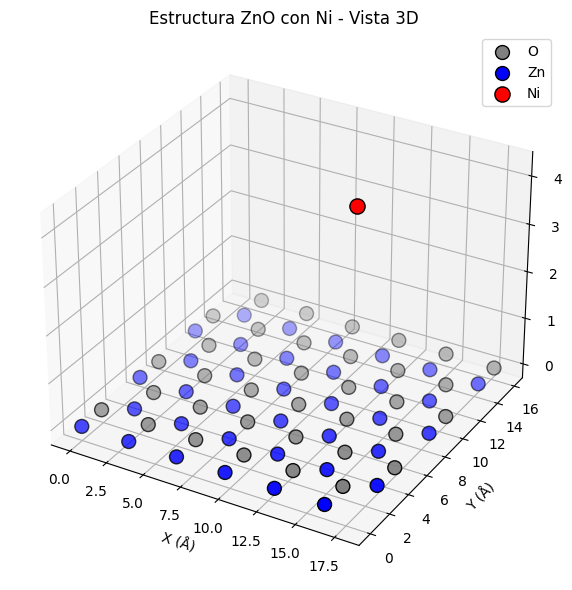

In [5]:
num_ni = 1  # número de iones Ni
z_min, z_max = 0.3 * SigmaO_Ni, 2.0 * SigmaZn_Ni  # altura en Å sobre la monocapa
radius_min, radius_max = 2.0, 5.0  # distancia lateral desde el centro

# Calcular centro de la estructura base
center = np.mean(positions, axis=0)

# Lista para almacenar posiciones de iones Ni
ni_positions = []

while len(ni_positions) < num_ni:
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    r = np.random.uniform(radius_min, radius_max)
    x, y = center[0:2] + r * direction
    z = np.random.uniform(z_min, z_max)
    ni_positions.append([x, y, z])

ni_positions = np.array(ni_positions)


# --- Gráfica 3D Interactiva con Plotly ---
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')
ax.scatter(ni_positions[:, 0], ni_positions[:, 1], ni_positions[:, 2],
           color='red', label='Ni', s=120, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()



# Definición del costo para entrenamiento y evaluación.

**Costo de entrenamiento**

In [6]:
# Lennard-Jones potential function
@tf.function
def physical_potential(r, epsilon, sigma, q_j):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon # Sumamos epsilon para dejar el fondo del pozo en 0
    coulomb = k_e * q_Ni * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Funcion para calcular el potencial de informacion, individual y cruzado
@tf.function
def calculate_cross_information_potential(points1, points2, sigma):
    """
    Calcula el Potencial de Información Cruzado (V) entre dos conjuntos de puntos.
    Si points1 y points2 son el mismo, calcula el Potencial de Información (IP).
    """
    diff = tf.expand_dims(points1, 1) - tf.expand_dims(points2, 0)
    sq_dists = tf.reduce_sum(tf.square(diff), axis=-1)
    kernel_matrix = tf.exp(-sq_dists / (2.0 * sigma**2))
    return tf.reduce_mean(kernel_matrix)
    
# Función de costo para el entrenamiento del modelo
@tf.function
def get_training_loss(positions, elements, ni_positions, pri_weight, lambda_pri, sigma_pri):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando un potencial fisico y una regularizacion por PRI.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor con etiquetas de tipo de atomo (num_superficie,)
        pri_weight,lambda_pri,sgma_pri: hiperparametros escalares que modelan el peso de la regulaización
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
    """
    
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ni_exp = tf.expand_dims(ni_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ni_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)
     
    # Casteamos las etiquetas para que tengan la forma de r
     elements_exp = tf.reshape(elements, (-1, 1))  # (num_atoms, 1)

    # Creamos una mascara para etiquetar las interacciones
     is_O = tf.equal(elements_exp, "O")
     is_Zn = tf.equal(elements_exp, "Zn")


    # Calculamos la energía aplicando cortes de distancia de interacción
     energy_O = tf.where(r < r_cutoffO_Ni,
                        physical_potential(r, EpsilonO_Ni, SigmaO_Ni,q_O),
                        tf.zeros_like(r))
     energy_Zn = tf.where(r < r_cutoffZn_Ni,
                         physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn),
                         tf.zeros_like(r))
    # Filtramos el valor de la energía dependiendo de la etiqueta
     atoms_energy_matrix = tf.where(is_O, energy_O,
                            tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)

    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Calculamos la energia promedio por ion considerando que no todos interactuan con la misma
    # cantidad de atomos.
    # Definimos mascaras para contar las interacciones validas
     mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
     mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
     interaction_mask_atoms = tf.maximum(mask_O, mask_Zn)  # shape: (num_atoms, num_ions)
    # Número de interacciones válidas por ion
     count_per_ion = tf.reduce_sum(interaction_mask_atoms, axis=0)  # shape: (num_ions,)
     count_per_ion_safe = tf.where(count_per_ion == 0, 1.0, count_per_ion)  # evitar división por cero
    # Energia promedio de cada ion
     mean_energy_per_ion = energy_per_ion / count_per_ion_safe  # shape: (num_ions,)
    #---------


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True
     mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                             physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni),
                             tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    
    # --------
    # Esta sección maneja la energía promedio por ion, por ahora no se esta usando
    # Número de interacciones válidas por ion
     count_per_ion_ion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32), axis=0)  # (num_ions,)
     count_per_ion_ion_safe = tf.where(count_per_ion_ion == 0, 1.0, count_per_ion_ion)
    # Energias promedio ion_ion
     mean_ion_ion_energy_per_ion = ion_ion_energy_per_ion / count_per_ion_ion_safe  # (num_ions,)
    #---------------
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy

    #--------------------REGULARIZACIÓN CON PRI----------------------
    # Analogía: positions -> majority class | ion_positions -> undersampled majority class 

     epsilon_log = 1e-10  # Para estabilidad numérica en el logaritmo

    # Calcular potenciales de información
     ip_ions = calculate_cross_information_potential(ni_positions, ni_positions, sigma_pri)
     ip_surface = calculate_cross_information_potential(positions, positions, sigma_pri) # Es constante, pero se calcula aquí por simplicidad
     cip_ions_surface = calculate_cross_information_potential(ni_positions, positions, sigma_pri)
    # Calcular entropías cuadráticas (H2 = -log(V))
     H2_ions = -tf.math.log(ip_ions + epsilon_log)
     H2_surface = -tf.math.log(ip_surface + epsilon_log)
     H2_cross = -tf.math.log(cip_ions_surface + epsilon_log)

    # Calcular Divergencia de Cauchy-Schwarz (D_cs= 2H2(ion,surface)- H2(ion)- H2(surface)) - Eq. 4 del paper
     D_cs = 2 * H2_cross - H2_ions - H2_surface
    # Calcular costo PRI - Eq. 7 del paper
    # J(X_hat) = H2(X_hat) + lambda * D_cs(X_hat, X)
     pri_cost = (1- lambda_pri)*H2_ions + 2*lambda_pri * D_cs

    #------------COMBINAR Y RETORNAR----------------

     total_loss = (1- pri_weight)*energy_total + pri_weight * pri_cost
    
     return  total_loss, energy_total_per_ion# si no es necesario, solo retorna la energia con minimo en 0

**Costo de evaluación**

In [7]:
@tf.function
def calculate_final_system_energy(positions, elements, ni_positions):
    """
    Calcula la energía del sistema sin PRI y corrige el shift potencial de la energía
    """
    pos_exp = tf.expand_dims(positions, axis=1)
    ni_exp = tf.expand_dims(ni_positions, axis=0)
    r = tf.norm(pos_exp - ni_exp, axis=2)
    elements_exp = tf.reshape(elements, (-1, 1))
    is_O = tf.equal(elements_exp, "O")
    is_Zn = tf.equal(elements_exp, "Zn")
    
    energy_O = tf.where(r < r_cutoffO_Ni, physical_potential(r, EpsilonO_Ni, SigmaO_Ni, q_O), tf.zeros_like(r))
    energy_Zn = tf.where(r < r_cutoffZn_Ni, physical_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn), tf.zeros_like(r))
    atoms_energy_matrix = tf.where(is_O, energy_O, tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))
    energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)

    diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)
    r_ion = tf.norm(diff_ion, axis=-1)
    eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)
    mask_offdiag = tf.logical_not(eye)
    mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)
    interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)
    valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))
    ion_energy_matrix = tf.where(interaction_mask_ions, physical_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni), tf.zeros_like(r_ion))
    ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)
    
    ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5
    physical_energy_total = tf.reduce_sum(energy_per_ion) + ion_ion_total_energy
    
    # --- Apply the final epsilon correction ---
    mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
    mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
    num_interactions_O = tf.reduce_sum(tf.cast(mask_O, tf.float32))
    num_interactions_Zn = tf.reduce_sum(tf.cast(mask_Zn, tf.float32))
    num_interactions_ionion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32))*0.5 #igual que en la energía, las interacciones se cuentan doble
    total_epsilon_shift = (
        num_interactions_O * EpsilonO_Ni +
        num_interactions_Zn * EpsilonZn_Ni +
        num_interactions_ionion * EpsilonNi_Ni
    )
    corrected_energy_total = physical_energy_total - total_epsilon_shift
    
    return corrected_energy_total, energy_per_ion + ion_ion_energy_per_ion

# Entrenamiento

** Convertir variables a tf**

In [8]:
#tensorflow data
ion = tf.Variable(ni_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)

**Definmos un exponential decay learning rate**

In [9]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** (epoch/5)

**Definimos clase para early stop**

In [10]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

**Loop de entrenamiento**

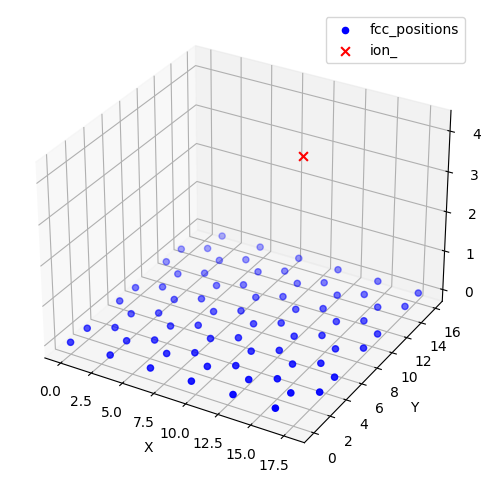

Epoch 1/200
Loss: 4.646839618682861 MeanGrad: [-0.18183261  0.18821263 -0.22013836]
Epoch 2/200
Loss: 3.1503193378448486 MeanGrad: [-0.0903217  0.2962328 -0.1306054]
Epoch 3/200
Loss: 3.1015377044677734 MeanGrad: [-0.08773484  0.2878625  -0.1238484 ]
Epoch 4/200
Loss: 1.6168882846832275 MeanGrad: [-0.17985898  0.17314097 -0.03058368]
Epoch 5/200
Loss: 0.16272345185279846 MeanGrad: [-0.08332736  0.06165049  0.06059402]
Epoch 5/200 | Loss: 0.1627 | LR: 0.0960
Epoch 6/200
Loss: 1.5982859134674072 MeanGrad: [ 0.01046224 -0.04886008 -0.02736581]
Epoch 7/200
Loss: 0.17087998986244202 MeanGrad: [ 0.13921411 -0.10816091  0.06095723]
Epoch 8/200
Loss: 1.6873531341552734 MeanGrad: [-0.01102631 -0.1255073  -0.04554248]
Epoch 9/200
Loss: 0.2529202103614807 MeanGrad: [ 0.11961709 -0.07586735  0.04553144]
Epoch 10/200
Loss: 0.2569146752357483 MeanGrad: [ 0.11942524 -0.07617657  0.04518392]
Epoch 10/200 | Loss: 0.2569 | LR: 0.0912
Epoch 11/200
Loss: 0.25785669684410095 MeanGrad: [ 0.11939585 -0.07607

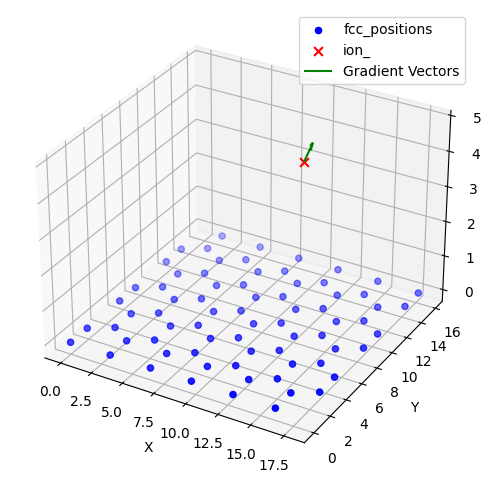

Epoch 16/200
Loss: 1.6845037937164307 MeanGrad: [-0.01084945 -0.12265636 -0.04580076]
Epoch 17/200
Loss: 0.24392744898796082 MeanGrad: [-0.10180325 -0.01741554  0.04750906]
Epoch 18/200
Loss: 0.2446092665195465 MeanGrad: [-0.10137057 -0.01728614  0.04745795]
Epoch 19/200
Loss: 0.24393653869628906 MeanGrad: [-0.10104905 -0.01705868  0.04762798]
Epoch 20/200
Loss: 0.24210432171821594 MeanGrad: [-0.1008317  -0.01674817  0.0479811 ]
Epoch 20/200 | Loss: 0.2421 | LR: 0.0823
Epoch 21/200
Loss: -1.2010152339935303 MeanGrad: [0.02797376 0.03656505 0.14148626]
Epoch 22/200
Loss: -1.2036914825439453 MeanGrad: [0.02782761 0.03710544 0.1411709 ]
Epoch 23/200
Loss: 0.23324590921401978 MeanGrad: [-0.10172726 -0.0161106   0.04880834]
Epoch 24/200
Loss: 0.22934648394584656 MeanGrad: [-0.10239348 -0.01595422  0.04906138]
Epoch 25/200
Loss: 1.6657766103744507 MeanGrad: [-0.01309898 -0.12439651 -0.04091142]
Epoch 25/200 | Loss: 1.6658 | LR: 0.0782
Epoch 26/200
Loss: 3.1106717586517334 MeanGrad: [ 0.07667

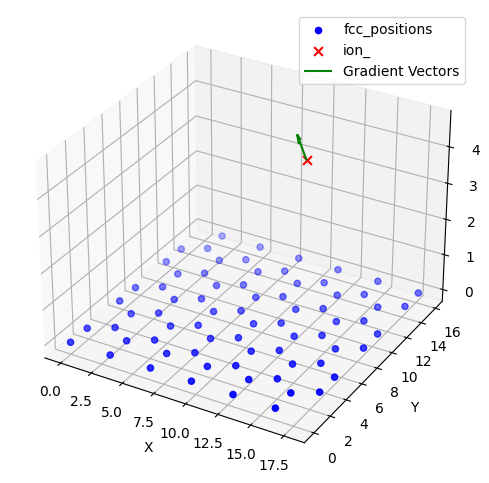

Epoch 31/200
Loss: 0.2259647250175476 MeanGrad: [-0.10303545  0.09342769  0.04928762]
Epoch 32/200
Loss: 0.22699469327926636 MeanGrad: [-0.10254621 -0.01573453  0.0492937 ]
Epoch 33/200
Loss: 0.22793033719062805 MeanGrad: [-0.10243058 -0.01580731  0.0492744 ]
Epoch 34/200
Loss: -1.2123981714248657 MeanGrad: [0.02737918 0.03799425 0.14038849]
Epoch 35/200
Loss: 1.6682467460632324 MeanGrad: [-0.01264953 -0.12394594 -0.0415873 ]
Epoch 35/200 | Loss: 1.6682 | LR: 0.0706
Epoch 36/200
Loss: 0.22796979546546936 MeanGrad: [ 0.11741116 -0.07053041  0.04927032]
Epoch 37/200
Loss: 1.6686723232269287 MeanGrad: [-0.01270808 -0.12415347 -0.04164509]
Epoch 38/200
Loss: 0.22704562544822693 MeanGrad: [-0.10280523 -0.01589328  0.04930591]
Epoch 39/200
Loss: 0.22615498304367065 MeanGrad: [-0.10278393 -0.01577456  0.04943137]
Epoch 40/200
Loss: 0.22554239630699158 MeanGrad: [ 0.11701082 -0.07017782  0.04948745]
Epoch 40/200 | Loss: 0.2255 | LR: 0.0670
Epoch 41/200
Loss: 1.6650749444961548 MeanGrad: [ 0.20

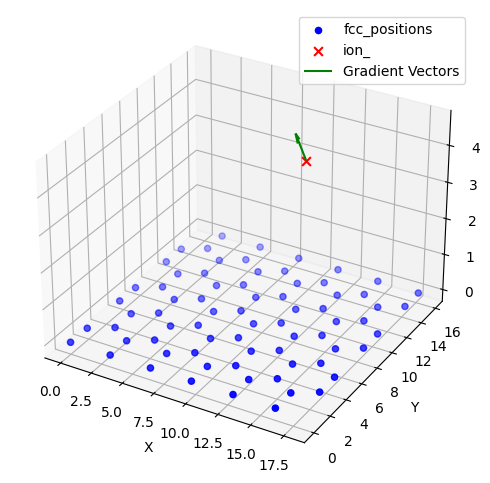

Epoch 46/200
Loss: 1.5956158638000488 MeanGrad: [ 0.008131   -0.04898039 -0.02651396]
Epoch 47/200
Loss: 1.595947265625 MeanGrad: [ 0.00835324 -0.04900653 -0.02660132]
Epoch 48/200
Loss: 1.5960361957550049 MeanGrad: [ 0.0084718  -0.04892348 -0.02664283]
Epoch 49/200
Loss: 1.595908522605896 MeanGrad: [ 0.00849796 -0.0487432  -0.02664489]
Epoch 50/200
Loss: 1.5955884456634521 MeanGrad: [ 0.00844252 -0.04847621 -0.02661029]
Epoch 50/200 | Loss: 1.5956 | LR: 0.0605
Epoch 51/200
Loss: 0.1551843285560608 MeanGrad: [-0.08237818  0.0600909   0.06314446]
Epoch 52/200
Loss: 0.15529727935791016 MeanGrad: [-0.08236349  0.06009594  0.06314759]
Epoch 53/200
Loss: 1.5952836275100708 MeanGrad: [ 0.00833571 -0.04835887 -0.0265575 ]
Epoch 54/200
Loss: 1.5953271389007568 MeanGrad: [ 0.0083056  -0.04848459 -0.0265491 ]
Epoch 55/200
Loss: 1.5951673984527588 MeanGrad: [ 0.0082015  -0.04849496 -0.02650557]
Epoch 55/200 | Loss: 1.5952 | LR: 0.0575
Epoch 56/200
Loss: 0.15431907773017883 MeanGrad: [-0.08244795 

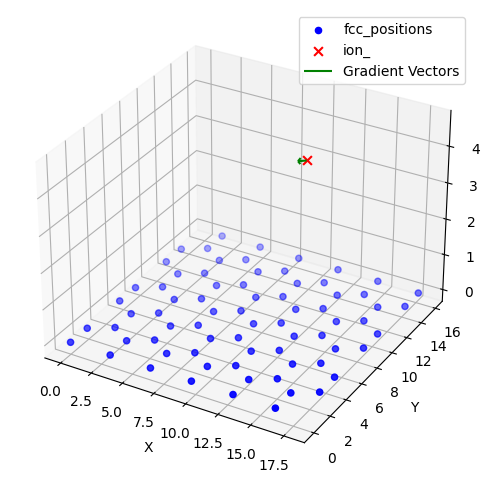

Epoch 61/200
Loss: 1.595220685005188 MeanGrad: [ 0.00766583  0.1690508  -0.0264211 ]
Epoch 62/200
Loss: 0.15351220965385437 MeanGrad: [-0.082247    0.05993222  0.06387135]
Epoch 63/200
Loss: 0.15451285243034363 MeanGrad: [ 0.13806753 -0.1040153   0.06369957]
Epoch 64/200
Loss: 0.15464523434638977 MeanGrad: [ 0.138263   -0.10428103  0.06359884]
Epoch 65/200
Loss: 1.595333218574524 MeanGrad: [ 0.00822896 -0.04922701 -0.02649278]
Epoch 65/200 | Loss: 1.5953 | LR: 0.0519
Epoch 66/200
Loss: 1.5952483415603638 MeanGrad: [ 0.00816726 -0.04895991 -0.02648266]
Epoch 67/200
Loss: 1.5949912071228027 MeanGrad: [ 0.00804182 -0.04862584 -0.02644259]
Epoch 68/200
Loss: 0.1546829640865326 MeanGrad: [-0.08254559  0.06027424  0.06325364]
Epoch 69/200
Loss: 0.15479299426078796 MeanGrad: [-0.08265902  0.06040027  0.06314865]
Epoch 70/200
Loss: 0.15402933955192566 MeanGrad: [-0.08282022  0.06046516  0.06315041]
Epoch 70/200 | Loss: 0.1540 | LR: 0.0493
Epoch 71/200
Loss: 3.036447763442993 MeanGrad: [ 0.0983

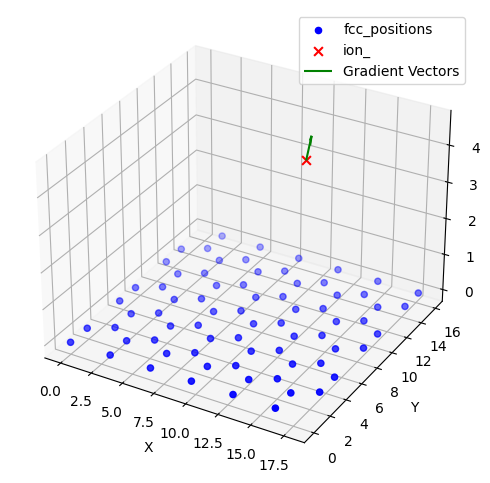

Epoch 76/200
Loss: 1.595311164855957 MeanGrad: [ 0.00789019 -0.04864332 -0.02643997]
Epoch 77/200
Loss: 1.5948318243026733 MeanGrad: [ 0.00771647 -0.04839025 -0.02636084]
Epoch 78/200
Loss: 0.1547611653804779 MeanGrad: [-0.08280888  0.06057689  0.06310783]
Epoch 79/200
Loss: 1.5959978103637695 MeanGrad: [ 0.00774502  0.16936366 -0.02657854]
Epoch 80/200
Loss: 0.154680997133255 MeanGrad: [-0.08271399  0.0604893   0.06322588]
Epoch 80/200 | Loss: 0.1547 | LR: 0.0445
Epoch 81/200
Loss: 1.5945374965667725 MeanGrad: [ 0.0076604  -0.04850478 -0.02630813]
Epoch 82/200
Loss: 1.5947421789169312 MeanGrad: [ 0.00775237 -0.04873027 -0.0263407 ]
Epoch 83/200
Loss: 1.5947643518447876 MeanGrad: [ 0.0077724  -0.04884871 -0.0263409 ]
Epoch 84/200
Loss: 1.5946229696273804 MeanGrad: [ 0.00772908 -0.04887192 -0.02631344]
Epoch 85/200
Loss: 1.5943362712860107 MeanGrad: [ 0.00762885 -0.04881021 -0.02625899]
Epoch 85/200 | Loss: 1.5943 | LR: 0.0422
Epoch 86/200
Loss: 1.5946993827819824 MeanGrad: [ 0.00762502

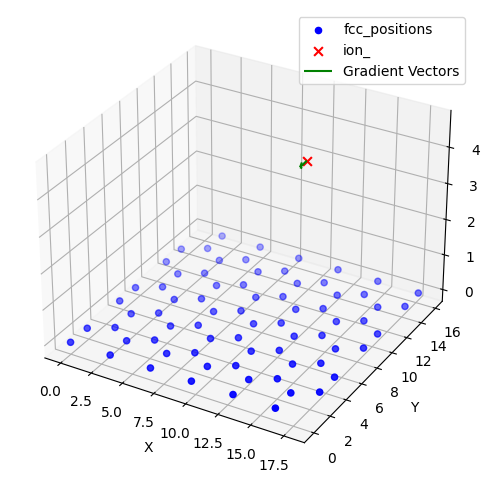

Epoch 91/200
Loss: -1.2139561176300049 MeanGrad: [0.02709141 0.03875425 0.14003684]
Epoch 92/200
Loss: -1.214777946472168 MeanGrad: [0.02710782 0.03884129 0.13996695]
Epoch 93/200
Loss: 1.665759563446045 MeanGrad: [ 0.20663455  0.0389514  -0.04079025]
Epoch 94/200
Loss: 3.035191535949707 MeanGrad: [ 0.09750217  0.06008009 -0.11630994]
Epoch 95/200
Loss: 0.15420019626617432 MeanGrad: [-0.08239394  0.06013299  0.06358685]
Epoch 95/200 | Loss: 0.1542 | LR: 0.0381
Epoch 96/200
Loss: 0.15435084700584412 MeanGrad: [-0.08244251  0.06015379  0.06343093]
Epoch 97/200
Loss: 1.5950738191604614 MeanGrad: [ 0.00808254 -0.04852265 -0.02646651]
Epoch 98/200
Loss: 1.5954285860061646 MeanGrad: [ 0.00822871 -0.04855357 -0.02653816]
Epoch 99/200
Loss: 1.5956053733825684 MeanGrad: [ 0.00830467 -0.04850833 -0.02657852]
Epoch 100/200
Loss: 1.5956237316131592 MeanGrad: [ 0.00831825 -0.0483958  -0.02658863]
Epoch 100/200 | Loss: 1.5956 | LR: 0.0362
Epoch 101/200
Loss: 1.5955010652542114 MeanGrad: [ 0.0082768 

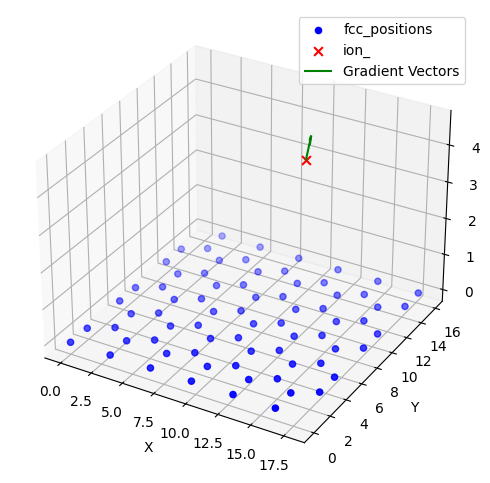

Epoch 106/200
Loss: 1.59556245803833 MeanGrad: [ 0.00810349 -0.04828066 -0.02653515]
Epoch 107/200
Loss: 1.595385193824768 MeanGrad: [ 0.00798844 -0.04822696 -0.02649212]
Epoch 108/200
Loss: 1.5950957536697388 MeanGrad: [ 0.00783446 -0.04811114 -0.02643107]
Epoch 109/200
Loss: 0.1547737419605255 MeanGrad: [-0.08301356  0.06072661  0.0628378 ]
Epoch 110/200
Loss: 1.595411777496338 MeanGrad: [ 0.0076877   0.16955869 -0.02646673]
Epoch 110/200 | Loss: 1.5954 | LR: 0.0327
Epoch 111/200
Loss: 0.15420126914978027 MeanGrad: [-0.08302963  0.06068952  0.06295483]
Epoch 112/200
Loss: 3.0360267162323 MeanGrad: [ 0.09833246  0.0605303  -0.11570379]
Epoch 113/200
Loss: 1.5953835248947144 MeanGrad: [ 0.00793337 -0.04861078 -0.02645933]
Epoch 114/200
Loss: 1.5954946279525757 MeanGrad: [ 0.00805756 -0.04869422 -0.0264981 ]
Epoch 115/200
Loss: 1.5954699516296387 MeanGrad: [ 0.00812026 -0.04870487 -0.02650969]
Epoch 115/200 | Loss: 1.5955 | LR: 0.0311
Epoch 116/200
Loss: 1.5953257083892822 MeanGrad: [ 0

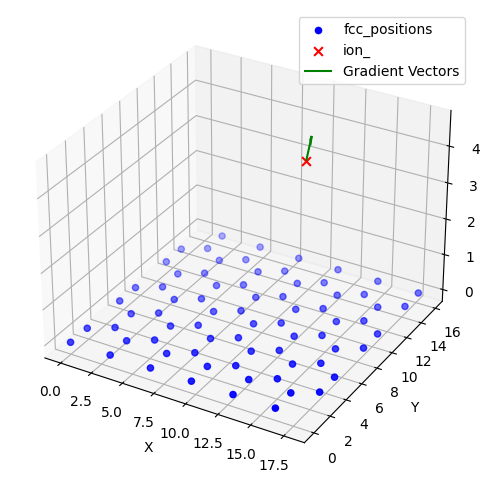

Epoch 121/200
Loss: 1.5947339534759521 MeanGrad: [ 0.00798305 -0.04870293 -0.02639402]
Epoch 122/200
Loss: 1.5946044921875 MeanGrad: [ 0.00791674 -0.04874037 -0.0263605 ]
Epoch 123/200
Loss: 0.15372022986412048 MeanGrad: [-0.08228639  0.05996653  0.0637438 ]
Epoch 124/200
Loss: 1.5943663120269775 MeanGrad: [ 0.00776502 -0.04885279 -0.02629117]
Epoch 125/200
Loss: 1.594244122505188 MeanGrad: [ 0.00767776 -0.04891828 -0.02625203]
Epoch 125/200 | Loss: 1.5942 | LR: 0.0280
Epoch 126/200
Loss: 4.546889305114746 MeanGrad: [-0.05370861  0.03889116 -0.22103645]
Epoch 127/200
Loss: -1.2158762216567993 MeanGrad: [0.02716168 0.03888485 0.13990086]
Epoch 128/200
Loss: -1.2151745557785034 MeanGrad: [0.02712515 0.03887711 0.13993742]
Epoch 129/200
Loss: 0.22570857405662537 MeanGrad: [0.11674783 0.14775091 0.04946315]
Epoch 130/200
Loss: 0.2251245379447937 MeanGrad: [ 0.1168368  -0.0701531   0.04949106]
Epoch 130/200 | Loss: 0.2251 | LR: 0.0266
Epoch 131/200
Loss: 0.22439298033714294 MeanGrad: [ 0.11

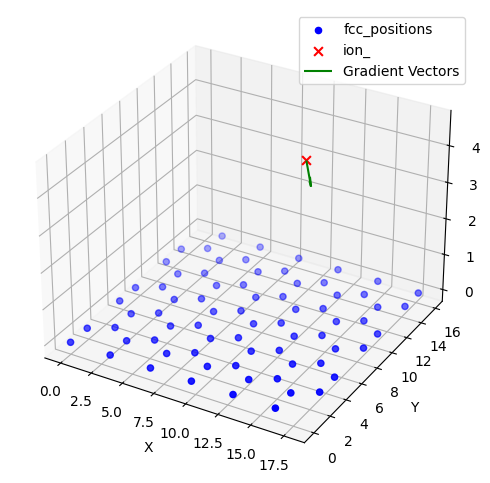

Epoch 136/200
Loss: 1.5945165157318115 MeanGrad: [ 0.00763655 -0.04852254 -0.02629946]
Epoch 137/200
Loss: 3.0356955528259277 MeanGrad: [ 0.09800202  0.06039604 -0.11594571]
Epoch 138/200
Loss: 1.5946862697601318 MeanGrad: [ 0.00767309 -0.04846837 -0.02632974]
Epoch 139/200
Loss: 0.15395140647888184 MeanGrad: [-0.08278583  0.06044237  0.06323144]
Epoch 140/200
Loss: 1.5947641134262085 MeanGrad: [ 0.00772715 -0.04838621 -0.02635625]
Epoch 140/200 | Loss: 1.5948 | LR: 0.0240
Epoch 141/200
Loss: 1.5947792530059814 MeanGrad: [ 0.00773086 -0.04836781 -0.02635946]
Epoch 142/200
Loss: 0.15402722358703613 MeanGrad: [-0.08282503  0.06048078  0.06316954]
Epoch 143/200
Loss: 1.5947868824005127 MeanGrad: [ 0.00770437 -0.04837881 -0.02635343]
Epoch 144/200
Loss: 1.594773292541504 MeanGrad: [ 0.00767431 -0.04839929 -0.02634344]
Epoch 145/200
Loss: 3.0356173515319824 MeanGrad: [ 0.09811531  0.06052604 -0.1158331 ]
Epoch 145/200 | Loss: 3.0356 | LR: 0.0228
Epoch 146/200
Loss: 0.154183030128479 MeanGra

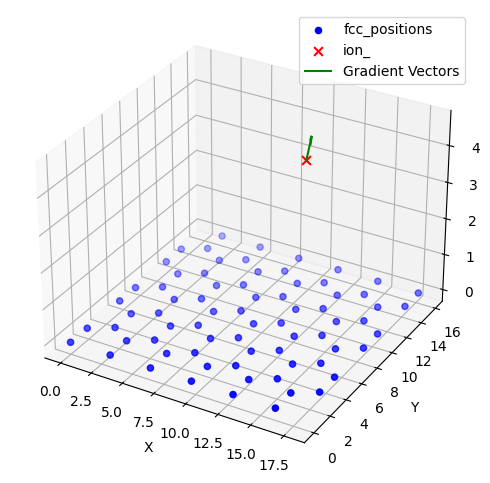

Epoch 151/200
Loss: 1.5947134494781494 MeanGrad: [ 0.00771582 -0.04856658 -0.02633748]
Epoch 152/200
Loss: 1.5945295095443726 MeanGrad: [ 0.0076426  -0.04851054 -0.02630216]
Epoch 153/200
Loss: 0.1539894938468933 MeanGrad: [-0.08267295  0.06037483  0.06339291]
Epoch 154/200
Loss: 1.5950466394424438 MeanGrad: [ 0.00764755  0.16924381 -0.02639006]
Epoch 155/200
Loss: 1.5945197343826294 MeanGrad: [ 0.00760351  0.16916467 -0.02629464]
Epoch 155/200 | Loss: 1.5945 | LR: 0.0206
Epoch 156/200
Loss: 1.5946314334869385 MeanGrad: [ 0.00775953 -0.04876615 -0.02632719]
Epoch 157/200
Loss: 1.5948150157928467 MeanGrad: [ 0.00789769 -0.04889394 -0.0263736 ]
Epoch 158/200
Loss: 1.5948964357376099 MeanGrad: [ 0.00798802 -0.04896454 -0.02639951]
Epoch 159/200
Loss: 1.5948855876922607 MeanGrad: [ 0.00803576 -0.04898451 -0.02640818]
Epoch 160/200
Loss: 1.5947959423065186 MeanGrad: [ 0.00804634 -0.04896    -0.0264009 ]
Epoch 160/200 | Loss: 1.5948 | LR: 0.0196
Epoch 161/200
Loss: 1.5946320295333862 MeanGra

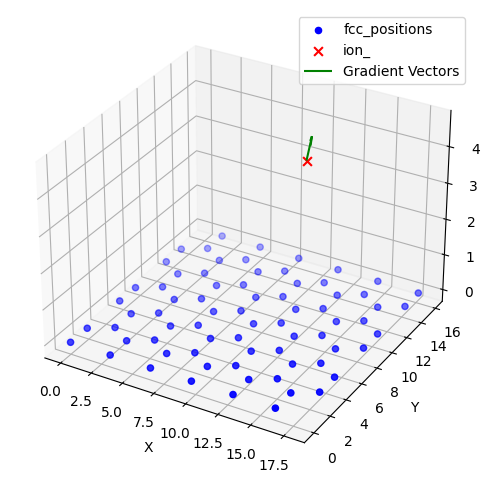

Epoch 166/200
Loss: 0.15352150797843933 MeanGrad: [-0.0820917   0.05977123  0.06397   ]
Epoch 167/200
Loss: 1.5943275690078735 MeanGrad: [ 0.00783143 -0.04895417 -0.02629411]
Epoch 168/200
Loss: 1.5942857265472412 MeanGrad: [ 0.00777348 -0.0489707  -0.02627533]
Epoch 169/200
Loss: 3.106302499771118 MeanGrad: [-0.14343111 -0.06992148 -0.13099904]
Epoch 170/200
Loss: -1.2168773412704468 MeanGrad: [0.02718948 0.03885408 0.13985988]
Epoch 170/200 | Loss: -1.2169 | LR: 0.0177
Epoch 171/200
Loss: 0.22449269890785217 MeanGrad: [0.11696564 0.14784764 0.04951256]
Epoch 172/200
Loss: 1.6653757095336914 MeanGrad: [ 0.2067488   0.03892647 -0.04072499]
Epoch 173/200
Loss: 4.546563148498535 MeanGrad: [-0.0536634   0.03888282 -0.22100928]
Epoch 174/200
Loss: 1.6650670766830444 MeanGrad: [-0.23313959  0.0388712  -0.04073178]
Epoch 175/200
Loss: -1.2162647247314453 MeanGrad: [0.0272091  0.03871838 0.13993731]
Epoch 175/200 | Loss: -1.2163 | LR: 0.0168
Epoch 176/200
Loss: 0.22480684518814087 MeanGrad: [

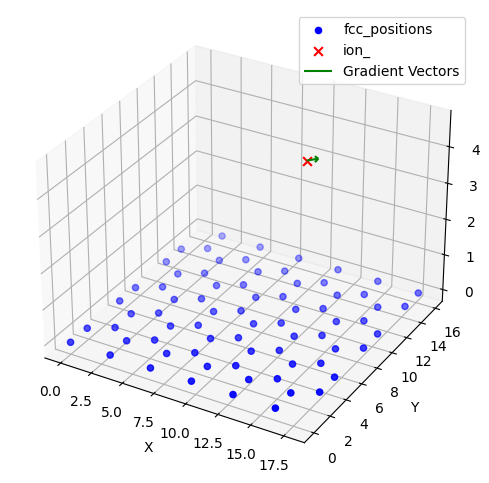

Epoch 181/200
Loss: -1.2164684534072876 MeanGrad: [0.02721435 0.03877797 0.13990852]
Epoch 182/200
Loss: 0.22412949800491333 MeanGrad: [ 0.11696377 -0.07004862  0.04958488]
Epoch 183/200
Loss: 1.6650091409683228 MeanGrad: [ 0.2067829   0.03886839 -0.04066814]
Epoch 184/200
Loss: 4.547092914581299 MeanGrad: [-0.05370269  0.03889857 -0.22101451]
Epoch 185/200
Loss: 3.1060404777526855 MeanGrad: [-0.14350842  0.14773178 -0.13090809]
Epoch 185/200 | Loss: 3.1060 | LR: 0.0151
Epoch 186/200
Loss: 0.22400188446044922 MeanGrad: [-0.10296477 -0.01558557  0.04959435]
Epoch 187/200
Loss: -1.2164065837860107 MeanGrad: [0.02718985 0.0387496  0.13991703]
Epoch 188/200
Loss: 0.22476917505264282 MeanGrad: [ 0.11698355 -0.07014097  0.04952021]
Epoch 189/200
Loss: 0.22475099563598633 MeanGrad: [ 0.11702668 -0.07017741  0.04950304]
Epoch 190/200
Loss: 1.6652134656906128 MeanGrad: [-0.01313596 -0.1244413  -0.04075205]
Epoch 190/200 | Loss: 1.6652 | LR: 0.0144
Epoch 191/200
Loss: 1.6649484634399414 MeanGrad

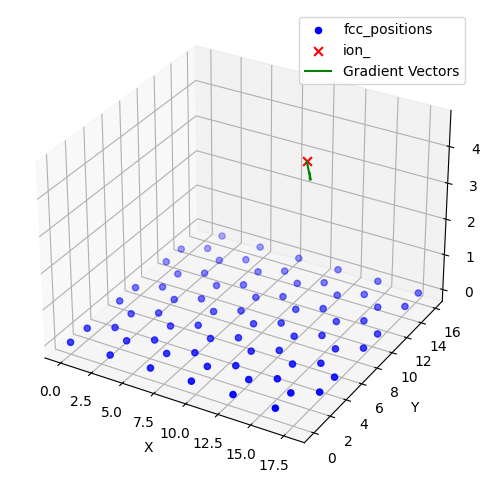

Epoch 196/200
Loss: 3.105595111846924 MeanGrad: [-0.14338978 -0.06996404 -0.1308687 ]
Epoch 197/200
Loss: 1.6649116277694702 MeanGrad: [-0.01317582 -0.12447108 -0.04067317]
Epoch 198/200
Loss: 0.22444769740104675 MeanGrad: [ 0.11698113 -0.0701424   0.04952442]
Epoch 199/200
Loss: 0.22440791130065918 MeanGrad: [ 0.11694027 -0.07010548  0.04954271]
Epoch 200/200
Loss: 1.664913296699524 MeanGrad: [ 0.20666881  0.03886276 -0.04066041]
Epoch 200/200 | Loss: 1.6649 | LR: 0.0130


In [11]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

# Custom training loop
eta0 = 0.1
epochs = 200
decay_rate = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
loss_history = []#Para guardar y graficar la energía del sistema

#Hiperparametros de regularización
#posiblemente los ajustemos con optimzación bayesiana
pri_weight = tf.constant(0.5, dtype=tf.float32) #Peso PRI vs Fisica
lambda_pri = tf.constant(0.5, dtype=tf.float32) #Peso Entropia ion-ion vs cruzada
sigma_pri = tf.constant(10, dtype=tf.float32 ) # Ancho del kernel


early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    optimizer.learning_rate.assign(eta)
    
    with tf.GradientTape() as g:
        g.watch(ion)
        H_loss,ion_total_energies = get_training_loss(sample_atoms,sample_elements,ion,pri_weight,lambda_pri,sigma_pri)
        loss_history.append(H_loss)
    grad_ = g.gradient(H_loss, ion)
    optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    """if early_stopping.on_epoch_end(epoch, H_loss.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        break"""
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {H_loss.numpy():.4f} | LR: {optimizer.learning_rate.numpy():.4f}')
    ion_ =  ion.numpy()
    gradN = -10*eta*grad_.numpy()
    # For quiver, we need to create a 3D representation of the gradient
    # Assuming gradN is a 2D array (num_ions, 2)
    gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
    gradN_3D = gradN  # Copy x and y components from gradN
    if (epoch+1)%15==0:
    
    
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
        ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')
    
        
    
        ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                  color='g', length=1, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
    
        #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
        plt.show()


# Evaluacion de la energía final

In [12]:
#Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
final_energy,_= calculate_final_system_energy(
    sample_atoms,  # Tensor con TODAS las posiciones de átomos de la superficie (Zn + O)
    sample_elements,   # Tensor con las etiquetas correspondientes
    ion
    )
    
# Pasa a numpy para reportes
system_energy = final_energy.numpy()

In [13]:
print(f'Atomos en la superficie: {num_atoms} - Iones a adsorber: {num_ni}')
print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(ion_total_energies):.5f} ev/atom") #Revisar
distance=ion_ - starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
print(f'Distancia viajada promedio (vectorial): {mean_vector}')
print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

Atomos en la superficie: 72 - Iones a adsorber: 1
Energía total del sistema:-0.03071 ev/atom
Energía promedio de adsorcion por ion:-0.03071 ev/atom
Desviación estándar de energía por ion: 0.00000 ev/atom
Distancia viajada promedio (vectorial): [ 0.548193   -0.37505627  0.43841267]
Distancia promedio recorrida (magnitud): 0.796 Å


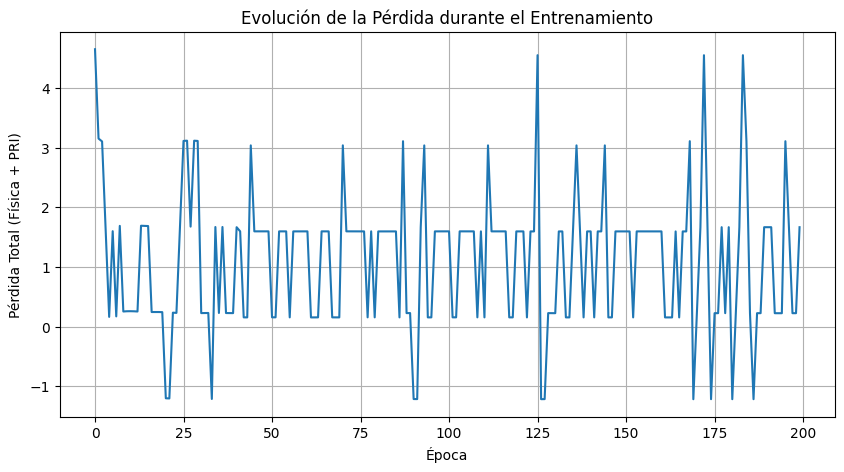

In [14]:
# --- Gráfica de la evolución de la pérdida ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Pérdida Total (Física + PRI)")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.grid(True)
plt.show()

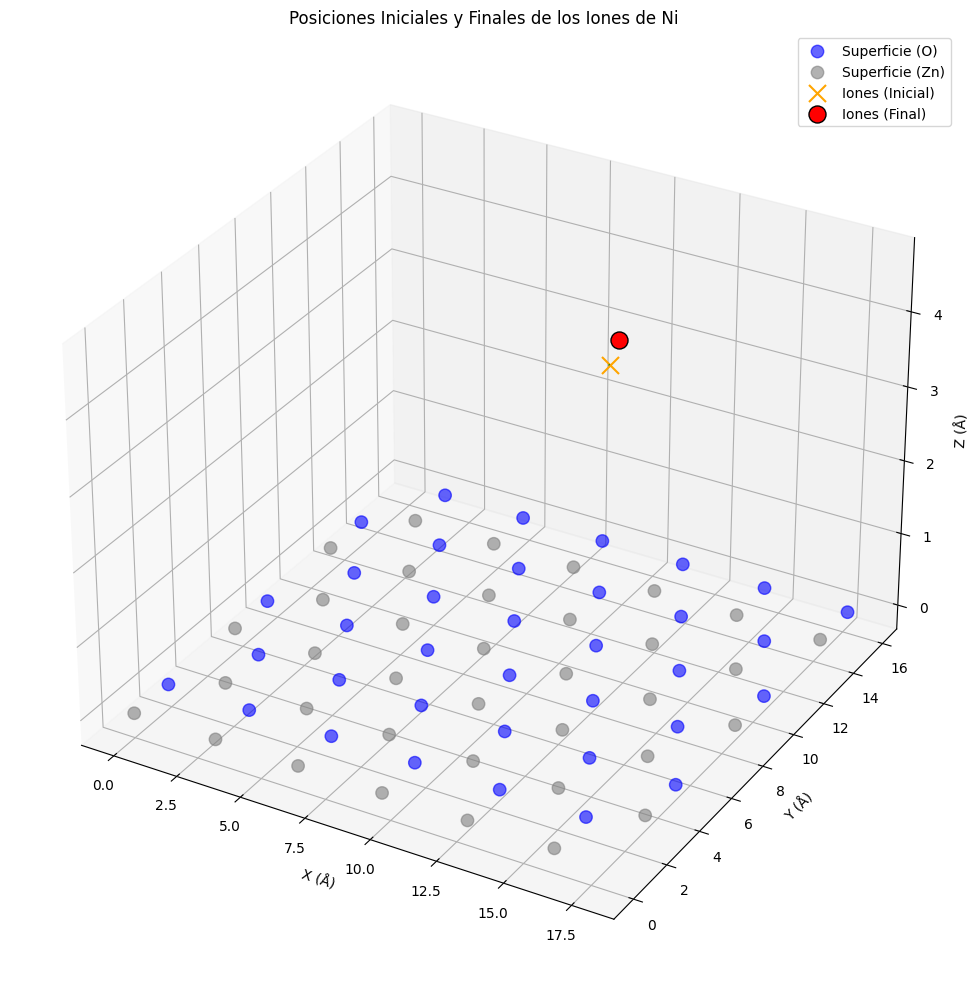

In [15]:
# --- Gráfica 3D de posiciones iniciales y finales ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Superficie
colors_map = {"Zn": "grey", "O": "blue"}
for atom_type in set(elements):
    idx = (elements == atom_type)
    ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2],
               color=colors_map.get(atom_type, "black"),
               label=f'Superficie ({atom_type})', s=80, alpha=0.6)

# Posiciones de los iones
ax.scatter(starting_pos[:, 0], starting_pos[:, 1], starting_pos[:, 2],
           color='orange', label='Iones (Inicial)', s=150, marker='x')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2],
           color='red', label='Iones (Final)', s=150, edgecolors='k')

# Flechas de trayectoria
for i in range(num_ni):
    ax.quiver(starting_pos[i, 0], starting_pos[i, 1], starting_pos[i, 2],
              gradN_3D[i, 0], gradN_3D[i, 1], gradN_3D[i, 2],
              color='green', arrow_length_ratio=0.3, alpha=0.7)

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Posiciones Iniciales y Finales de los Iones de Ni")
ax.legend()
plt.tight_layout()
plt.show()